<a href="https://colab.research.google.com/github/kenechiomeke/FakeNewsBuster/blob/main/Transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code from siamese-bert github

In [ ]:
# !pip install pytorch_pretrained_bert

In [ ]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification


# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('https://cdn.huggingface.co/bert-base-uncased-vocab.txt')

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from argparse import ArgumentParser
import sys

100%|██████████| 231508/231508 [00:00<00:00, 6110393.99B/s]


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import numpy as np

def set_seed(seed=None):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  print(f'Random seed {seed} has been set.')


set_seed(seed=2023)  # change 2023 with any number you like

Random seed 2023 has been set.


In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# set device
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

GPU is enabled in this notebook.
Random seed 2021 has been set.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
data_path='/content/drive/My Drive/nma/datasets/'

train_path = data_path + 'train.tsv'
test_path = data_path + 'test.tsv'
val_path = data_path + 'valid.tsv'

train_df = pd.read_csv(train_path, sep="\t", header=None)
test_df = pd.read_csv(test_path, sep="\t", header=None)
val_df = pd.read_csv(val_path, sep="\t", header=None)

# Fill nan (empty boxes) with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
val_df = val_df.fillna(0)

train = train_df.values
test = test_df.values
val = val_df.values

In [ ]:
labels = {'train':[train[i][1] for i in range(len(train))], 'test':[test[i][1] for i in range(len(test))], 'val':[val[i][1] for i in range(len(val))]}
statements = {'train':[train[i][2] for i in range(len(train))], 'test':[test[i][2] for i in range(len(test))], 'val':[val[i][2] for i in range(len(val))]}
subjects = {'train':[train[i][3] for i in range(len(train))], 'test':[test[i][3] for i in range(len(test))], 'val':[val[i][3] for i in range(len(val))]}
speakers = {'train':[train[i][4] for i in range(len(train))], 'test':[test[i][4] for i in range(len(test))], 'val':[val[i][4] for i in range(len(val))]}
jobs = {'train':[train[i][5] for i in range(len(train))], 'test':[test[i][5] for i in range(len(test))], 'val':[val[i][5] for i in range(len(val))]}
states = {'train':[train[i][6] for i in range(len(train))], 'test':[test[i][6] for i in range(len(test))], 'val':[val[i][6] for i in range(len(val))]}
affiliations = {'train':[train[i][7] for i in range(len(train))], 'test':[test[i][7] for i in range(len(test))], 'val':[val[i][7] for i in range(len(val))]}
credits = {'train':[train[i][8:13] for i in range(len(train))], 'test':[test[i][8:13] for i in range(len(test))], 'val':[val[i][8:13] for i in range(len(val))]}
contexts = {'train':[train[i][13] for i in range(len(train))], 'test':[test[i][13] for i in range(len(test))], 'val':[val[i][13] for i in range(len(val))]}
# justification = {'train':[train[i][15] for i in range(len(train))], 'test':[test[i][15] for i in range(len(test))], 'val':[val[i][15] for i in range(len(val))]}


def to_onehot(a):
  a_cat = [0]*len(a)
  for i in range(len(a)):
      if a[i]=='true':
          a_cat[i] = [1,0,0,0,0,0]
      elif a[i]=='mostly-true':
          a_cat[i] = [0,1,0,0,0,0]
      elif a[i]=='half-true':
          a_cat[i] = [0,0,1,0,0,0]
      elif a[i]=='barely-true':
          a_cat[i] = [0,0,0,1,0,0]
      elif a[i]=='false':
          a_cat[i] = [0,0,0,0,1,0]
      elif a[i]=='pants-fire':
          a_cat[i] = [0,0,0,0,0,1]
      else:
          print('Incorrect label')
  return a_cat

labels_onehot = {'train':to_onehot(labels['train']), 'test':to_onehot(labels['test']), 'val':to_onehot(labels['val'])}


In [ ]:
# Preparing meta data

#credit['train'][2]
num_labels = 6

metadata = {'train':[0]*len(train), 'val':[0]*len(val), 'test':[0]*len(test)}

for i in range(len(train)):
    subject = subjects['train'][i]
    if subject == 0:
        subject = 'None'

    speaker = speakers['train'][i]
    if speaker == 0:
        speaker = 'None'

    job = jobs['train'][i]
    if job == 0:
        job = 'None'

    state = states['train'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['train'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['train'][i]
    if context == 0 :
        context = 'None'

    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context

    metadata['train'][i] = meta

for i in range(len(val)):
    subject = subjects['val'][i]
    if subject == 0:
        subject = 'None'

    speaker = speakers['val'][i]
    if speaker == 0:
        speaker = 'None'

    job = jobs['val'][i]
    if job == 0:
        job = 'None'

    state = states['val'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['val'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['val'][i]
    if context == 0 :
        context = 'None'

    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context

    metadata['val'][i] = meta

for i in range(len(test)):
    subject = subjects['test'][i]
    if subject == 0:
        subject = 'None'

    speaker = speakers['test'][i]
    if speaker == 0:
        speaker = 'None'

    job = jobs['test'][i]
    if job == 0:
        job = 'None'

    state = states['test'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['test'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['test'][i]
    if context == 0 :
        context = 'None'

    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context

    metadata['test'][i] = meta


# Credit score calculation
pad_len = 64 # NOTE: changed this from 2304 to 1536 because we were getting errors
credit_score = {'train':[0]*len(train), 'val':[0]*len(val), 'test':[0]*len(test)}
for i in range(len(train)):
    credit = credits['train'][i]
    if sum(credit) == 0:
        score = 0.5
    else:
        score = (credit[3]*0.2 + credit[2]*0.5 + credit[0]*0.75 + credit[1]*0.9 + credit[4]*1)/(sum(credit))
    credit_score['train'][i] = [score for i in range(pad_len)]

for i in range(len(val)):
    credit = credits['val'][i]
    if sum(credit) == 0:
        score = 0.5
    else:
        score = (credit[3]*0.2 + credit[2]*0.5 + credit[0]*0.75 + credit[1]*0.9 + credit[4]*1)/(sum(credit))
    credit_score['val'][i] = [score for i in range(pad_len)]

for i in range(len(test)):
    credit = credits['test'][i]
    if sum(credit) == 0:
        score = 0.5
    else:
        score = (credit[3]*0.2 + credit[2]*0.5 + credit[0]*0.75 + credit[1]*0.9 + credit[4]*1)/(sum(credit))
    credit_score['test'][i] = [score for i in range(pad_len)]


In [ ]:
# initialize bert
class BertLayerNorm(nn.Module):
        def __init__(self, hidden_size, eps=1e-12):
            """Construct a layernorm module in the TF style (epsilon inside the square root).
            Note: TF maybe means tensorflow?? we don't know why they're doing this like this
            """
            super(BertLayerNorm, self).__init__()
            self.weight = nn.Parameter(torch.ones(hidden_size))
            self.bias = nn.Parameter(torch.zeros(hidden_size))
            self.variance_epsilon = eps

        def forward(self, x):
            u = x.mean(-1, keepdim=True)
            s = (x - u).pow(2).mean(-1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.variance_epsilon)
            return self.weight * x + self.bias


class BertForSequenceClassification(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary. Items in the batch should begin with the special "CLS" token. (see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """

    def __init__(self, num_labels=2): # Change number of labels here.
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        num_inputs = 2
        self.classifier = nn.Linear(config.hidden_size*num_inputs, num_labels)
        #self.fc1 = nn.Linear(config.hidden_size*2, 512)
        # initializing weights to a normal distribution
        nn.init.xavier_normal_(self.classifier.weight)

    '''def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output'''

    def forward_once(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        #logits = self.classifier(pooled_output)

        return pooled_output

    def forward(self, input_ids1, input_ids2): #, credit_sc):
        # forward pass of input 1 - statement
        output1 = self.forward_once(input_ids1, token_type_ids=None, attention_mask=None, labels=None)
        # forward pass of input 2 - metadate
        output2 = self.forward_once(input_ids2, token_type_ids=None, attention_mask=None, labels=None)

        # output3 = self.forward_once(input_ids3, token_type_ids=None, attention_mask=None, labels=None)
        out = torch.cat((output1, output2), 1)

        # MM Note: remove the credit score
        # # Multiply the credit score with the output after concatnation
        # out = torch.add(credit_sc, out)

        #out = self.fc1(out)
        logits = self.classifier(out)

        return logits

    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True


from pytorch_pretrained_bert import BertConfig

h_size = 768 # was 768 originally for some reason

## original
# config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=h_size,
#         num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

config = BertConfig(vocab_size_or_config_json_file=3200, hidden_size=h_size,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)


model = BertForSequenceClassification(num_labels)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [ ]:
# Loading the statements
X_train = statements['train']
y_train = labels_onehot['train']

X_val = statements['val']
y_val = labels_onehot['val']

X_train = X_train + X_val
y_train = y_train + y_val

X_test = statements['test']
y_test = labels_onehot['test']

In [ ]:
len(X_train)

11524

In [ ]:
# # Loading the justification
# X_train_just = justification['train']

# X_val_just = justification['val']

# X_train_just = X_train_just + X_val_just

# X_test_just = statements['test']


# Loading the meta data
X_train_meta = metadata['train']
X_val_meta = metadata['val']
X_train_meta = X_train_meta + X_val_meta
X_test_meta = metadata['test']

# Loading Credit scores

X_train_credit = credit_score['train']
X_val_credit = credit_score['val']
X_train_credit = X_train_credit+X_val_credit
X_test_credit = credit_score['test']

In [ ]:
len(credit_score['train'][0])

64

In [ ]:
# Small data partitioned for debugging
'''X_train = X_train[:100]
y_train = y_train[:100]

X_test = X_test[:100]
y_test = y_test[:100]

X_train_just = X_train_just[:100]
X_test_just = X_test_just[:100]

X_train_meta = X_train_meta[:100]
X_test_meta = X_test_meta[:100]

X_train_credit = X_train_credit[:100]
X_test_credit = X_test_credit[:100]'''

# max_seq_length_stat = 64
# max_seq_length_just = 256
# max_seq_length_meta = 32

max_seq_length_stat = 32
max_seq_length_meta = 32

class text_dataset(Dataset):
    def __init__(self,x_y_list, transform=None):

        self.x_y_list = x_y_list
        self.transform = transform

    def __getitem__(self,index):

        # Tokenize statements
        tokenized_review = tokenizer.tokenize(self.x_y_list[0][index])

        if len(tokenized_review) > max_seq_length_stat:
            tokenized_review = tokenized_review[:max_seq_length_stat]

        ids_review  = tokenizer.convert_tokens_to_ids(tokenized_review)

        padding = [0] * (max_seq_length_stat - len(ids_review))

        ids_review += padding

        assert len(ids_review) == max_seq_length_stat

        #print(ids_review)
        ids_review = torch.tensor(ids_review)

        fakeness = self.x_y_list[4][index] # color
        list_of_labels = [torch.from_numpy(np.array(fakeness))]


        # Tokenize justifications
        #print(self.x_y_list[1][6833])
        #print(index)

        # Making sure that if there is no justification in a row(nan value converted to 0 using pandas), give it a justification called 'No justification' for training to be possible.
        if self.x_y_list[1][index] == 0:
            self.x_y_list[1][index] = 'No justification'

        tokenized_review_just = tokenizer.tokenize(self.x_y_list[1][index])

        if len(tokenized_review_just) > max_seq_length_just:
            tokenized_review_just = tokenized_review_just[:max_seq_length_just]

        ids_review_just  = tokenizer.convert_tokens_to_ids(tokenized_review_just)

        padding = [0] * (max_seq_length_just - len(ids_review_just))

        ids_review_just += padding

        assert len(ids_review_just) == max_seq_length_just

        #print(ids_review)
        ids_review_just = torch.tensor(ids_review_just)

        fakeness = self.x_y_list[4][index] # color
        list_of_labels = [torch.from_numpy(np.array(fakeness))]

        # Tokenize metadata

        tokenized_review_meta = tokenizer.tokenize(self.x_y_list[2][index])

        if len(tokenized_review_meta) > max_seq_length_meta:
            tokenized_review_meta = tokenized_review_meta[:max_seq_length_meta]

        ids_review_meta  = tokenizer.convert_tokens_to_ids(tokenized_review_meta)

        padding = [0] * (max_seq_length_meta - len(ids_review_meta))

        ids_review_meta += padding

        assert len(ids_review_meta) == max_seq_length_meta

        #print(ids_review)
        ids_review_meta = torch.tensor(ids_review_meta)

        fakeness = self.x_y_list[4][index] # color
        list_of_labels = [torch.from_numpy(np.array(fakeness))]

        credit_scr = self.x_y_list[3][index] # Credit score

        #ones_768 = np.ones((768))
        #credit_scr = credit_scr * ones_768
        credit_scr = torch.tensor(credit_scr)

        return [ids_review, ids_review_just, ids_review_meta, credit_scr], list_of_labels[0]

    def __len__(self):
        return len(self.x_y_list[0])


batch_size = 16

# Train Statements and Justifications
train_lists = [X_train, X_train_meta, X_train_credit, y_train]


# Test Statements and Justifications
test_lists = [X_test, X_train_meta, X_test_credit, y_test]
# test_lists = [X_test, X_test_just, X_train_meta, X_test_credit, y_test]


# Preparing the data (Tokenize)
training_dataset = text_dataset(x_y_list = train_lists)
test_dataset = text_dataset(x_y_list = test_lists)


# Prepare the training dictionaries
dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
                   }
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

In [ ]:
# Small data partitioned for debugging
'''X_train = X_train[:100]
y_train = y_train[:100]

X_test = X_test[:100]
y_test = y_test[:100]

X_train_just = X_train_just[:100]
X_test_just = X_test_just[:100]

X_train_meta = X_train_meta[:100]
X_test_meta = X_test_meta[:100]

X_train_credit = X_train_credit[:100]
X_test_credit = X_test_credit[:100]'''

# X_train = X_train[:100]
# y_train = y_train[:100]

# X_test = X_test[:100]
# y_test = y_test[:100]

# X_train_meta = X_train_meta[:100]
# X_test_meta = X_test_meta[:100]

# X_train_credit = X_train_credit[:100]
# X_test_credit = X_test_credit[:100]


# max_seq_length_stat = 64
# max_seq_length_just = 256
# max_seq_length_meta = 32

max_seq_length_stat = 64
max_seq_length_just = 0
max_seq_length_meta = 32

# input: [X_train, X_train_meta, X_train_credit, y_train]

class text_dataset(Dataset):
    def __init__(self,x_y_list, transform=None):

        self.x_y_list = x_y_list
        self.transform = transform

    def __getitem__(self,index):

        # Tokenize statements - index = 0
        tokenized_review = tokenizer.tokenize(self.x_y_list[0][index])

        if len(tokenized_review) > max_seq_length_stat:
            tokenized_review = tokenized_review[:max_seq_length_stat]

        ids_review  = tokenizer.convert_tokens_to_ids(tokenized_review)

        padding = [0] * (max_seq_length_stat - len(ids_review))

        ids_review += padding

        assert len(ids_review) == max_seq_length_stat

        #print(ids_review)
        ids_review = torch.tensor(ids_review)

        fakeness = self.x_y_list[-1][index] # color
        list_of_labels = [torch.from_numpy(np.array(fakeness))]


        # Tokenize justifications
        #print(self.x_y_list[1][6833])
        #print(index)

        # Making sure that if there is no justification in a row(nan value converted to 0 using pandas), give it a justification called 'No justification' for training to be possible.
        # if self.x_y_list[1][index] == 0:
            # self.x_y_list[1][index] = 'No justification'

        # tokenized_review_just = tokenizer.tokenize(self.x_y_list[1][index])

        # if len(tokenized_review_just) > max_seq_length_just:
            # tokenized_review_just = tokenized_review_just[:max_seq_length_just]

        # ids_review_just  = tokenizer.convert_tokens_to_ids(tokenized_review_just)

        # padding = [0] * (max_seq_length_just - len(ids_review_just))

        # ids_review_just += padding

        # assert len(ids_review_just) == max_seq_length_just

        #print(ids_review)
        # ids_review_just = torch.tensor(ids_review_just)

        # fakeness = self.x_y_list[4][index] # color
        # list_of_labels = [torch.from_numpy(np.array(fakeness))]

        # Tokenize metadata

        tokenized_review_meta = tokenizer.tokenize(self.x_y_list[1][index])

        if len(tokenized_review_meta) > max_seq_length_meta:
            tokenized_review_meta = tokenized_review_meta[:max_seq_length_meta]

        ids_review_meta  = tokenizer.convert_tokens_to_ids(tokenized_review_meta)

        padding = [0] * (max_seq_length_meta - len(ids_review_meta))

        ids_review_meta += padding

        assert len(ids_review_meta) == max_seq_length_meta

        #print(ids_review)
        ids_review_meta = torch.tensor(ids_review_meta)

        fakeness = self.x_y_list[-1][index] # color
        list_of_labels = [torch.from_numpy(np.array(fakeness))]

        credit_scr = self.x_y_list[2][index] # Credit score

        #ones_768 = np.ones((768))
        #credit_scr = credit_scr * ones_768
        credit_scr = torch.tensor(credit_scr)

        return [ids_review, ids_review_meta, credit_scr], list_of_labels[0]

    def __len__(self):
        return len(self.x_y_list[0])


In [ ]:
batch_size = 64 #16

# Train Statements and Justifications
train_lists = [X_train, X_train_meta, X_train_credit, y_train]


# Test Statements and Justifications
test_lists = [X_test, X_train_meta, X_test_credit, y_test]
# test_lists = [X_test, X_test_just, X_train_meta, X_test_credit, y_test]


# Preparing the data (Tokenize)
training_dataset = text_dataset(x_y_list = train_lists)
test_dataset = text_dataset(x_y_list = test_lists)

In [ ]:
len(train_lists[0])

11524

In [ ]:
training_dataset[0][0][0].shape

torch.Size([64])

In [ ]:
training_dataset[0][0][1].shape

torch.Size([32])

In [ ]:
training_dataset[0][0][2].shape

torch.Size([64])

In [ ]:
# Prepare the training dictionaries
dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
                   }
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_acc = []
val_acc = []
train_loss = []
val_loss = []

cuda:0


In [ ]:
dataloaders_dict['train']

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100
    best_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            fakeness_corrects = 0


            # Iterate over data.
            for inputs, fakeness in dataloaders_dict[phase]:

                # input 1 shape: torch.Size([16, 64])
                # input 3 shape: torch.Size([16, 32])
                # input 4 shape: torch.Size([16, 2304])

                inputs1 = inputs[0] # News statement input
                # inputs2 = inputs[1] # Justification input
                inputs3 = inputs[1] # Meta data input

                # inputs4 = inputs[2] # Credit scores input

                inputs1 = inputs1.to(device)
                # inputs2 = inputs2.to(device)
                inputs3 = inputs3.to(device)
                # inputs4 = inputs4.to(device)

                fakeness = fakeness.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #print(inputs)
                    outputs = model(inputs1, inputs3) #, inputs4)

                    outputs = F.softmax(outputs,dim=1)

                    loss = criterion(outputs, torch.max(fakeness.float(), 1)[1])
                    # backward + optimize only if in training phase
                    if phase == 'train':

                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs1.size(0)


                fakeness_corrects += torch.sum(torch.max(outputs, 1)[1] == torch.max(fakeness, 1)[1])


            epoch_loss = running_loss / dataset_sizes[phase]


            fakeness_acc = fakeness_corrects.double() / dataset_sizes[phase]

            print('{} total loss: {:.4f} '.format(phase, epoch_loss ))
            print('{} fakeness_acc: {:.4f}'.format(
                phase, fakeness_acc))

            # Saving training acc and loss for each epoch
            fakeness_acc1 = fakeness_acc.data
            fakeness_acc1 = fakeness_acc1.cpu()
            fakeness_acc1 = fakeness_acc1.numpy()
            train_acc.append(fakeness_acc1)

            #epoch_loss1 = epoch_loss.data
            #epoch_loss1 = epoch_loss1.cpu()
            #epoch_loss1 = epoch_loss1.numpy()
            train_loss.append(epoch_loss)

            if phase == 'val': #and fakeness_acc > best_acc:
                # print('Saving with accuracy of {}'.format(fakeness_acc),
                      # 'improved over previous {}'.format(best_acc))
                best_acc = fakeness_acc

                # Saving val acc and loss for each epoch
                fakeness_acc1 = fakeness_acc.data
                fakeness_acc1 = fakeness_acc1.cpu()
                fakeness_acc1 = fakeness_acc1.numpy()
                val_acc.append(fakeness_acc1)

                #epoch_loss1 = epoch_loss.data
                #epoch_loss1 = epoch_loss1.cpu()
                #epoch_loss1 = epoch_loss1.numpy()
                val_loss.append(epoch_loss)

                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'bert_model_test_noFC1_triBERT_binary_focalloss.pth')

        print('Time taken for epoch'+ str(epoch+1)+ ' is ' + str((time.time() - epoch_start)/60) + ' minutes')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_acc)))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, train_loss, val_loss

model.to(device)


lrlast = .0001
lrmain = .00001
optim1 = optim.Adam(
    [
        {"params":model.bert.parameters(),"lr": lrmain},
        {"params":model.classifier.parameters(), "lr": lrlast},

   ])

#optim1 = optim.Adam(model.parameters(), lr=0.001)#,momentum=.9)
# Observe that all parameters are being optimized
optimizer_ft = optim1
criterion = nn.CrossEntropyLoss()

'''import focal_loss
loss_args = {"alpha": 0.5, "gamma": 2.0}
criterion = focal_loss.FocalLoss(*loss_args)'''

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)


model_ft1, train_acc, val_acc, train_loss, val_loss = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)



starting
Epoch 1/5
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train total loss: 1.7758 
train fakeness_acc: 0.2070
val total loss: 1.7707 
val fakeness_acc: 0.2092
Time taken for epoch1 is 3.652491823832194 minutes

Epoch 2/5
----------
train total loss: 1.7675 
train fakeness_acc: 0.2261
val total loss: 1.7575 
val fakeness_acc: 0.2478
Time taken for epoch2 is 3.6941370526949564 minutes

Epoch 3/5
----------
train total loss: 1.7489 
train fakeness_acc: 0.2582
val total loss: 1.7544 
val fakeness_acc: 0.2510
Time taken for epoch3 is 3.697904320557912 minutes

Epoch 4/5
----------
train total loss: 1.7443 
train fakeness_acc: 0.2648
val total loss: 1.7539 
val fakeness_acc: 0.2502
Time taken for epoch4 is 3.6989697138468425 minutes

Epoch 5/5
----------
train total loss: 1.7398 
train fakeness_acc: 0.2731
val total loss: 1.7531 
val fakeness_acc: 0.2581
Time taken for epoch5 is 3.7228988726933796 minutes

Training complete in 18m 28s
Best val Acc: 0.258090


In [ ]:
val_acc

[array(0.20915549), array(0.24782952), array(0.25098658), array(0.25019732), array(0.25808998)]
[1.7706973023930213, 1.7575317172432097, 1.754359760431201, 1.7539338518901424, 1.753079380213791]


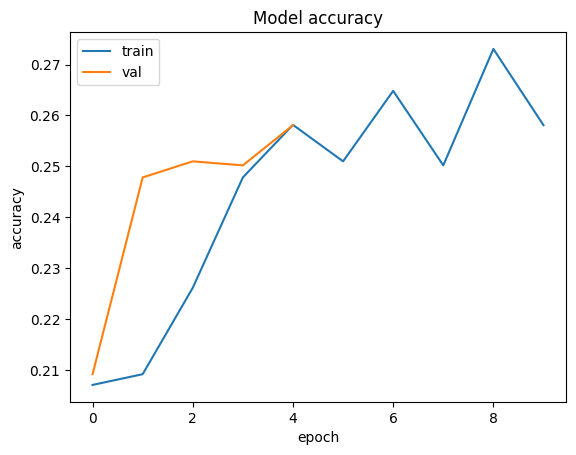

Saved Accuracy plot


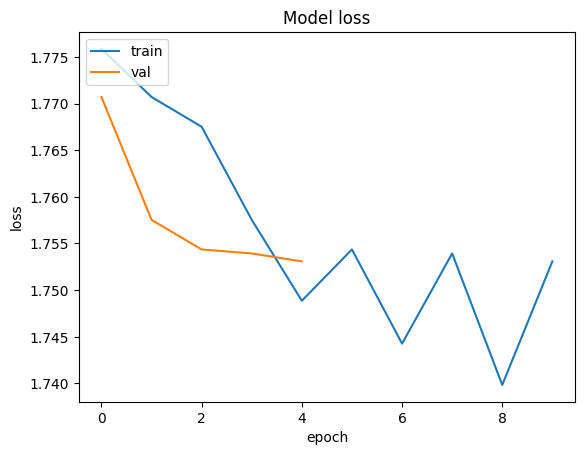

Saved Loss plot


In [ ]:
# Accuracy plots
print(val_acc)
print(val_loss)

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()
# plt.savefig('accuracy.png')
# plt.close()

print('Saved Accuracy plot')

# Loss plots

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()
# plt.savefig('loss.png')
# plt.close()

print('Saved Loss plot')

In [ ]:
# print the number of parameters in the model
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 109491462
Number of trainable parameters: 109491462
